# Predict box office revenue of movies

## Goal:
 Predict the revenue of a movie based on information which is available before the movie is released
## Process:
1. Get data from the database
 2. Check for missing values/Clean Data
3. Create new features
4. Normalize/Standardize Data
5. Train different models + optimize hyperparameters
6. Evaluate the models (loss, Score, SHAP)
7. Save the best model
## Result:
 The best model is a MLPRegressor with a mean squared error of 0.00019. Only about 5000 movies suit the criteria (over 26.000 in database).

## Improvements:
- Get missing values from Imdb/wikipedia
- Improve prediction with other features

In [152]:
# Import all necessary libraries
import os
import psycopg2
import pandas as pd
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

In [190]:
# Set global settings

save_models = True
plot_feature_distribution_for_training = False
search_for_best_hyperparameters = False
save_shape_plot = True

# Get data and explore it

In [191]:
# Database connection parameters
db_params = {
    'dbname': 'movie_db', 
    'user': 'postgres', 
    'password': os.environ['POSTGRES_PASSWORD'], 
    'host': '49.13.1.33',
    'port': '5333'
}

# Connection
conn = psycopg2.connect(**db_params)

# Helper function to query the database
def query_db(sql_query, conn):
    return pd.read_sql_query(sql_query, conn)

In [192]:
movies = query_db("""
SELECT * FROM Movies
""", conn)

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


In [193]:
# Print how many movies are in the database
print(f"There are {len(movies)} movies in the database.")
# Print how many movies don't have a budget or have 0 as a budget
print(f"There are {len(movies[movies['budget'].isna()])} movies without a budget.")
print(f"There are {len(movies[movies['budget'] == 0])} movies with 0 as a budget.")

There are 26683 movies in the database.
There are 0 movies without a budget.
There are 19504 movies with 0 as a budget.


In [194]:
# TODO: Don't throw away movies without a budget/revenue --> get from Imdb
movies = query_db("""
SELECT 
    m.id,
    m.budget,
    m.runtime,
    m.original_language,
    m.revenue,
    m.title,
    m.adult,
    STRING_AGG(g.name, ', ') AS genres,
    STRING_AGG(pc.name, ', ') AS production_companies,
    STRING_AGG(DISTINCT mpc2.iso_3166_1, ', ') AS production_countries
FROM 
    Movies m
LEFT JOIN 
    MovieGenres mg ON m.id = mg.movie_id
LEFT JOIN 
    Genres g ON mg.genre_id = g.id
LEFT JOIN 
    MovieProductionCompanies mpc ON m.id = mpc.movie_id
LEFT JOIN 
    ProductionCompanies pc ON mpc.production_company_id = pc.id
LEFT JOIN
    MovieProductionCountries mpc2 ON m.id = mpc2.movie_id
WHERE m.budget > 0 AND m.revenue > 0 AND pc.name IS NOT NULL AND g.name IS NOT NULL AND m.runtime > 0 AND mpc2.iso_3166_1 IS NOT NULL
GROUP BY 
    m.id
""", conn)

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


In [195]:
movies.head()

,id,budget,runtime,original_language,revenue,title,adult,genres,production_companies,production_countries
0,5,4000000.0,98,en,4257354.0,Four Rooms,False,"Comedy, Comedy","Miramax, A Band Apart",US
1,6,21000000.0,109,en,12136938.0,Judgment Night,False,"Action, Thriller, Crime, Action, Thriller, Crime","JVC, JVC, LARGO Entertainment, LARGO Entertain...",US
2,11,11000000.0,121,en,775398007.0,Star Wars,False,"Adventure, Science Fiction, Adventure, Action,...","Lucasfilm Ltd., 20th Century Fox, 20th Century...",US
3,12,94000000.0,100,en,940335536.0,Finding Nemo,False,"Animation, Family","Pixar, Pixar",US
4,13,55000000.0,142,en,677387716.0,Forrest Gump,False,"Romance, Comedy, Drama, Comedy, Romance, Drama...","Paramount, Paramount, Wendy Finerman Productio...",US




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<Axes: xlabel='production_countries', ylabel='Density'>

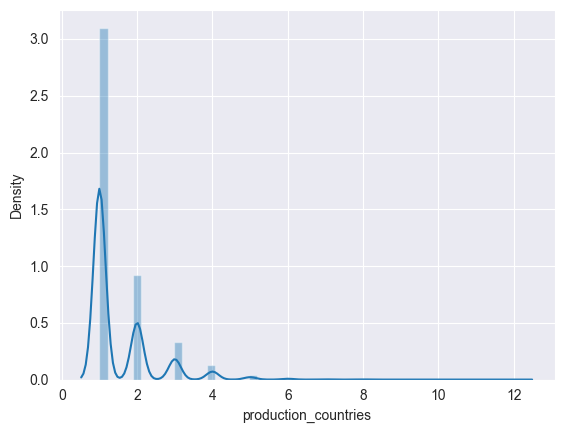

In [196]:
# Print the distribution of number of production countries
sns.distplot(movies['production_countries'].apply(lambda x: len(x.split(", "))))

In [197]:
# Print how many movies are in the database
print(f"There are {len(movies)} movies in the database.")
# Print how many movies don't have a budget or have 0 as a budget
print(f"There are {len(movies[movies['budget'].isna()])} movies without a budget.")
print(f"There are {len(movies[movies['budget'] == 0])} movies with 0 as a budget.")

There are 5457 movies in the database.
There are 0 movies without a budget.
There are 0 movies with 0 as a budget.


In [198]:
movies.describe()
movies.any().isna()

id                      False
budget                  False
runtime                 False
original_language       False
revenue                 False
title                   False
adult                   False
genres                  False
production_companies    False
production_countries    False
dtype: bool

In [199]:
# Print unique values for original_language
print(movies['original_language'].unique())
print(len(movies['original_language'].unique()))

['en' 'de' 'es' 'zh' 'ja' 'da' 'fr' 'it' 'pt' 'ko' 'cn' 'ru' 'ro' 'hi'
 'sv' 'th' 'nl' 'el' 'no' 'fa' 'he' 'tr' 'nb' 'ar' 'ta' 'te' 'id' 'pl'
 'hu' 'fi' 'bn' 'ml' 'uk' 'cs' 'ur' 'la' 'gl' 'ca' 'ms']
39


In [200]:
# Find all genres and count the occurrences
genres = [genre for sublist in movies['genres'].str.split(', ') for genre in set(sublist)]
genre_counts = Counter(genres)

sorted_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)
for genre, count in sorted_genres:
    print(f"{genre}: {count}")

print(set(genres))
print(len(genres))

Drama: 2380
Comedy: 1892
Action: 1542
Thriller: 1523
Adventure: 1147
Romance: 910
Crime: 893
Science Fiction: 705
Horror: 705
Fantasy: 661
Family: 632
Mystery: 515
Animation: 372
History: 285
War: 215
Music: 173
Western: 103
Documentary: 25
TV Movie: 5
{'Music', 'Mystery', 'Western', 'Animation', 'Action', 'Comedy', 'History', 'TV Movie', 'Romance', 'Horror', 'Crime', 'Fantasy', 'Adventure', 'War', 'Family', 'Documentary', 'Thriller', 'Drama', 'Science Fiction'}
14683


In [201]:
# Find all production companies and count the occurrences
production_companies = [company for sublist in movies['production_companies'].str.split(', ') for company in set(sublist)]
company_counts = Counter(production_companies)

sorted_companies = sorted(company_counts.items(), key=lambda x: x[1], reverse=True)

print(set(production_companies))
print(len(production_companies))

{'Venus Castina Productions', 'Artista Management', 'SMTS', 'Beijing Century Media Culture', 'Breaking In Pictures', 'Versátil Cinema', 'Saga Film', 'Ciné B', 'Elgin International Films', 'Vistamar Filmproduktion', 'Death Wish 5 Productions', 'Fellah Pictures', 'NBC Productions', 'Pistachio Pictures', 'Lege Artis', 'Les Productions du Chicon', 'KDDI', 'Tinker Productions', 'Breaker', 'Atípica Films', 'Black Bicycle Entertainment', 'Celandine Films', 'Triple Threat Talent', 'Kasander Film Company', 'Groenlandia', 'Forest Park Pictures', 'Constellation Entertainment', 'A Loopy Production LLC', 'Beryl Betty', 'Dippermouth', 'Blood & Wine Productions', 'Syndicate Films International', 'Maximum Effort', 'Assemblage Entertainment', 'Eighty Two Films', 'Icarus', 'Revere Pictures', 'Zeta Film', 'Shane Carruth', 'Rogue Films', 'BDE Entertainment', 'Hemisphere Media Capital', 'Detour Filmproduction', 'Jesse Films Inc.', 'Ministry of Culture of the Slovak Republic', 'Horseshoe Bay Productions', '

# Create new features from existing data

In [202]:
# For every film check whether it is in the top 100 production companies
top_100_companies = [company for company, count in sorted_companies[:100]]
movies['top_100_company'] = movies['production_companies'].apply(lambda x: any([company in x.split(", ") for company in top_100_companies]))

# For every film check whether it is in the top 5 genres
top_5_genres = [genre for genre, count in sorted_genres[:5]]
movies['top_5_genre'] = movies['genres'].apply(lambda x: any([genre in x.split(", ") for genre in top_5_genres]))


# Create two boolean features for if the production country is US and if it is UK
# (while exploring features these two countries had the most influence on the revenue)
movies['production_country_is_us'] = movies['production_countries'].apply(lambda x: 1 if 'US' in x.split(", ") else 0)
movies['production_country_is_uk'] = movies['production_countries'].apply(lambda x: 1 if 'UK' in x.split(", ") else 0)

movies.head()

,id,budget,runtime,original_language,revenue,title,adult,genres,production_companies,production_countries,top_100_company,top_5_genre,production_country_is_us,production_country_is_uk
0,5,4000000.0,98,en,4257354.0,Four Rooms,False,"Comedy, Comedy","Miramax, A Band Apart",US,True,True,1,0
1,6,21000000.0,109,en,12136938.0,Judgment Night,False,"Action, Thriller, Crime, Action, Thriller, Crime","JVC, JVC, LARGO Entertainment, LARGO Entertain...",US,False,True,1,0
2,11,11000000.0,121,en,775398007.0,Star Wars,False,"Adventure, Science Fiction, Adventure, Action,...","Lucasfilm Ltd., 20th Century Fox, 20th Century...",US,True,True,1,0
3,12,94000000.0,100,en,940335536.0,Finding Nemo,False,"Animation, Family","Pixar, Pixar",US,True,False,1,0
4,13,55000000.0,142,en,677387716.0,Forrest Gump,False,"Romance, Comedy, Drama, Comedy, Romance, Drama...","Paramount, Paramount, Wendy Finerman Productio...",US,True,True,1,0


## Other features tried but not used:

### Number of production companies
```python
movies['number_of_production_companies'] = movies['production_companies'].apply(lambda x: len(x.split(", ")))
```

### Length of the title
```python
#movies['title_length'] = movies['title'].apply(lambda x: len(x))
```
### Budget divided by number of production companies
```python
# Create new helpful features budget divided by number of production companies
#movies['budget_to_production_companies'] = movies['budget'] / movies['production_companies'].apply(lambda x: len(x.split(", ")))
```
### Budget divided by runtime
```python
# Create new helpful feature budget divided by runtime
#movies['budget_to_runtime'] = movies['budget'] / movies['runtime']
```

### Budget divided by number of genres
```python
# Splitting the production_countries column into separate rows for each country
#ovies = movies.assign(production_countries=movies['production_countries'].str.split(', ')).explode('production_countries')
```
### One-hot encoding for the production_countries
```python
# Creating one-hot encoding for the production_countries
#ovies = pd.get_dummies(movies,columns=['production_countries'], prefix='country')
```

In [203]:
# See how many movies are in the top 100 production companies
movies['top_100_company'].value_counts()

top_100_company
True     4151
False    1306
Name: count, dtype: int64

In [204]:
# One Hot encode the original_language column and genres column
movies = pd.get_dummies(movies, columns=['original_language'])

## Other one-hot encodings tried but not used:

### Split genres and take the first one as the genre
```python
#movies['genres'] = movies['genres'].apply(lambda x: x.split(", ")[0])
```
### One-hot encoding for the genres
```python
#movies = pd.get_dummies(movies, columns=['genres'])
```
### One-hot encoding for the production_companies
```python
# Only set bool if language is english
#movies['original_language'] = movies['original_language'].apply(lambda x: 1 if x == 'en' else 0)
```


In [205]:
movies.head()

,id,budget,runtime,revenue,title,adult,genres,production_companies,production_countries,top_100_company,...,original_language_ro,original_language_ru,original_language_sv,original_language_ta,original_language_te,original_language_th,original_language_tr,original_language_uk,original_language_ur,original_language_zh
0,5,4000000.0,98,4257354.0,Four Rooms,False,"Comedy, Comedy","Miramax, A Band Apart",US,True,...,False,False,False,False,False,False,False,False,False,False
1,6,21000000.0,109,12136938.0,Judgment Night,False,"Action, Thriller, Crime, Action, Thriller, Crime","JVC, JVC, LARGO Entertainment, LARGO Entertain...",US,False,...,False,False,False,False,False,False,False,False,False,False
2,11,11000000.0,121,775398007.0,Star Wars,False,"Adventure, Science Fiction, Adventure, Action,...","Lucasfilm Ltd., 20th Century Fox, 20th Century...",US,True,...,False,False,False,False,False,False,False,False,False,False
3,12,94000000.0,100,940335536.0,Finding Nemo,False,"Animation, Family","Pixar, Pixar",US,True,...,False,False,False,False,False,False,False,False,False,False
4,13,55000000.0,142,677387716.0,Forrest Gump,False,"Romance, Comedy, Drama, Comedy, Romance, Drama...","Paramount, Paramount, Wendy Finerman Productio...",US,True,...,False,False,False,False,False,False,False,False,False,False


In [206]:
# Drop unnecessary columns
movies.drop(['id', 'production_companies', 'title', 'genres', 'adult', 'production_countries'], axis=1, inplace=True)

movies.head()

,budget,runtime,revenue,top_100_company,top_5_genre,production_country_is_us,production_country_is_uk,original_language_ar,original_language_bn,original_language_ca,...,original_language_ro,original_language_ru,original_language_sv,original_language_ta,original_language_te,original_language_th,original_language_tr,original_language_uk,original_language_ur,original_language_zh
0,4000000.0,98,4257354.0,True,True,1,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,21000000.0,109,12136938.0,False,True,1,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,11000000.0,121,775398007.0,True,True,1,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,94000000.0,100,940335536.0,True,False,1,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,55000000.0,142,677387716.0,True,True,1,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Normalize/Standardize Data for better performance

In [207]:
# Selecting the columns for normalization and standardization
columns_to_scale = [ 'runtime', 'budget'] 
target_column = 'revenue'

# Creating scaler
min_max_scaler = MinMaxScaler()

# Applying Min-Max Normalization
normalized_data = min_max_scaler.fit_transform(movies[columns_to_scale])
normalized_df = pd.DataFrame(normalized_data, columns=columns_to_scale)
normalized_df.head()

# Normalize the target column
movies[target_column] = min_max_scaler.fit_transform(movies[[target_column]])

# Save the scaler for later use
if save_models:
    with open('min_max_scaler.pkl', 'wb') as f:
        pickle.dump(min_max_scaler, f)

In [208]:
# Merge dataframes
movies[columns_to_scale] = normalized_df

In [209]:
# Extract target column
target = movies['revenue']
movies.drop(['revenue'], axis=1, inplace=True)
movies.head()

,budget,runtime,top_100_company,top_5_genre,production_country_is_us,production_country_is_uk,original_language_ar,original_language_bn,original_language_ca,original_language_cn,...,original_language_ro,original_language_ru,original_language_sv,original_language_ta,original_language_te,original_language_th,original_language_tr,original_language_uk,original_language_ur,original_language_zh
0,0.008696,0.383399,True,True,1,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.045652,0.426877,False,True,1,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0.023913,0.474308,True,True,1,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.204348,0.391304,True,False,1,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0.119565,0.557312,True,True,1,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [210]:
# Print distribution of every feature
if plot_feature_distribution_for_training:
    for column in movies.columns:
        if column.startswith('original_language'):
            continue
        sns.distplot(movies[column]) 
        plt.show()

# Create train and test set

In [211]:
# Split in train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(movies, target, test_size=0.2, random_state=42)

# Experiment with different models

In [212]:
# Linear Regression
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

# Evaluate the model
y_pred = linear_regression.predict(X_test)

print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")
print(f"Model Score: {linear_regression.score(X_test, y_test)}")

Mean squared error: 0.0022569509081765337
Model Score: 0.5031280671750267


Mean squared error: 0.0025537346106779928
Model Score: 0.43779058404297555


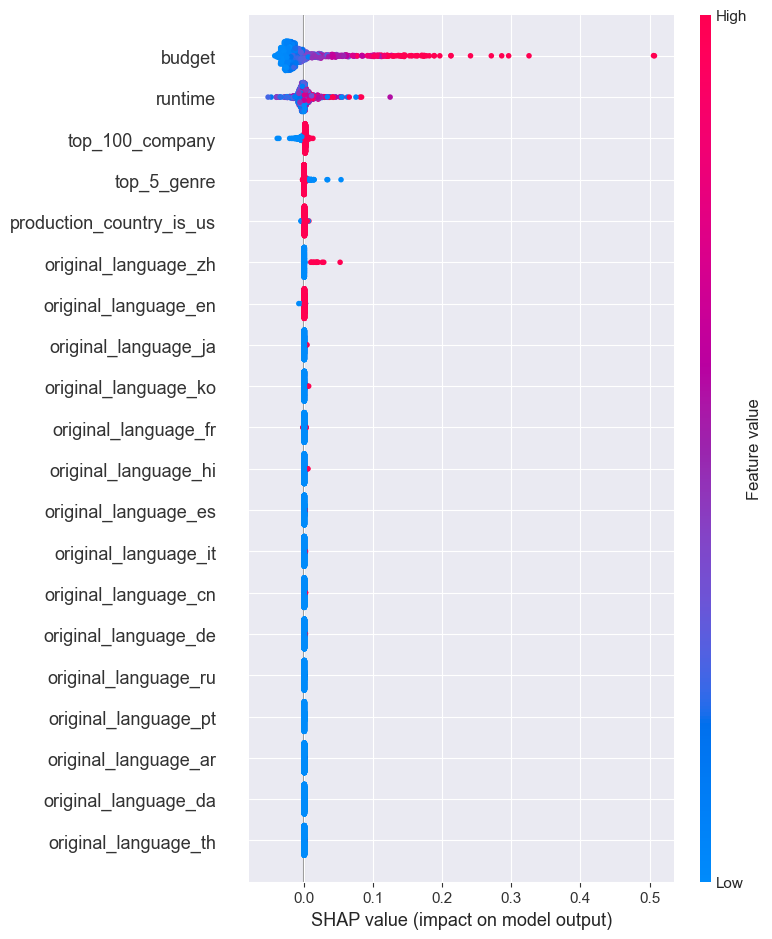

In [213]:
# Random Forest
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
# Evaluate the model
y_pred = random_forest.predict(X_test)

print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")
print(f"Model Score: {random_forest.score(X_test, y_test)}")

explainer = shap.TreeExplainer(random_forest)
shap_values = explainer.shap_values(X_test)

plt.savefig('models/shap/shap_random_forest.png') if save_shape_plot else None
shap.summary_plot(shap_values, X_test)

Mean squared error initial model: 0.0023156319044071367
Model Score initial model: 0.49020933690421575


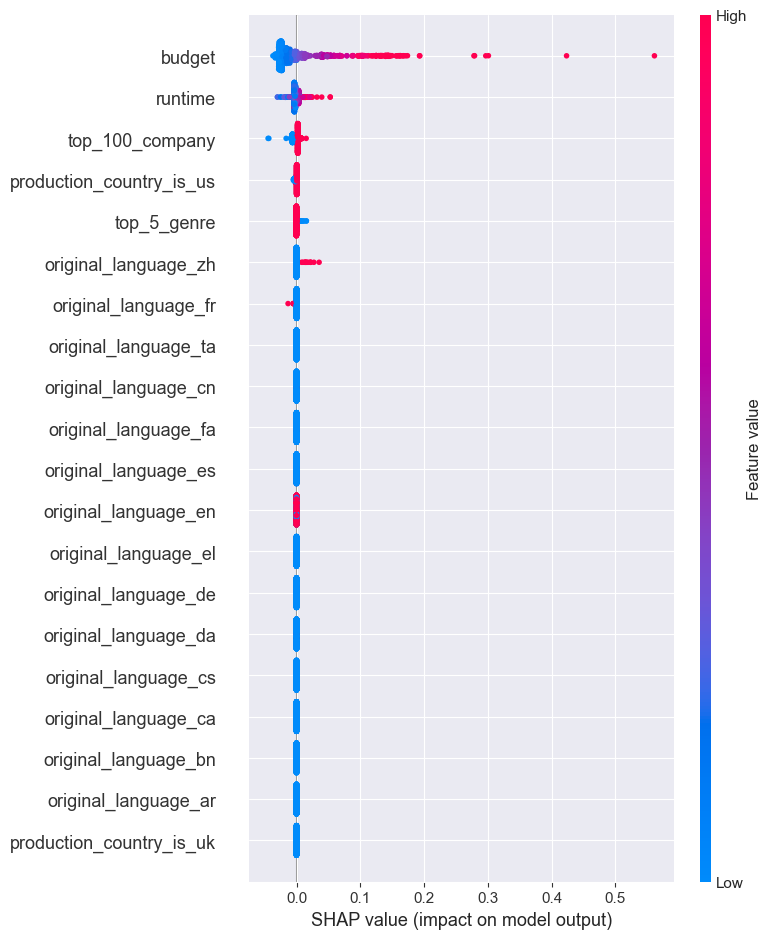

In [214]:
# Gradient Boosting
gradient_boosting = GradientBoostingRegressor()
gradient_boosting.fit(X_train, y_train)
# Evaluate the model
y_pred = gradient_boosting.predict(X_test)

print(f"Mean squared error initial model: {mean_squared_error(y_test, y_pred)}")
print(f"Model Score initial model: {gradient_boosting.score(X_test, y_test)}")

# Hyperparameter tuning
if search_for_best_hyperparameters:
    
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 1]
    }
    
    grid_search = GridSearchCV(GradientBoostingRegressor(), param_grid, cv=5, n_jobs=-1)
    
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")

    # Use best parameters
    gradient_boosting = GradientBoostingRegressor(**grid_search.best_params_)
    gradient_boosting.fit(X_train, y_train)
    # Evaluate the model
    y_pred = gradient_boosting.predict(X_test)
    
    print(f"Mean squared error of fine-tuned model: {mean_squared_error(y_test, y_pred)}")
    print(f"Model Score of fine-tuned model: {gradient_boosting.score(X_test, y_test)}")

# Use SHAP to explain the predictions
explainer = shap.TreeExplainer(gradient_boosting)
shap_values = explainer.shap_values(X_test)

plt.savefig('models/shap/shap_gradient_boosting.png') if save_shape_plot else None
shap.summary_plot(shap_values, X_test)

In [215]:
# Simple Neural Network
mlp = MLPRegressor()
mlp.fit(X_train, y_train)

# Evaluate the model
y_pred = mlp.predict(X_test)

print(f"Mean squared error of simple model: {mean_squared_error(y_test, y_pred)}")
print(f"Model Score of simple model: {mlp.score(X_test, y_test)}")

# Extract the original values from the normalized values
original_values = min_max_scaler.inverse_transform(y_pred.reshape(-1, 1))

Mean squared error of simple model: 0.002283584585088027
Model Score of simple model: 0.49726461375328557




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



Mean difference: 9802234.707678117


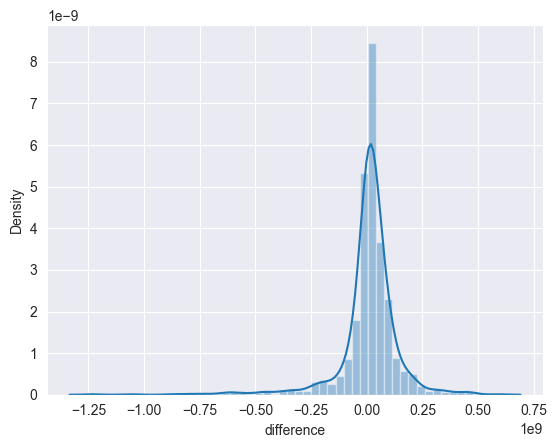

In [216]:
# Create a dataframe with the predictions and the actual values
predictions_df = pd.DataFrame({
    'predicted_revenue': original_values.reshape(-1),
    'actual_revenue': min_max_scaler.inverse_transform(y_test.values.reshape(-1, 1)).reshape(-1)
})

# Calculate the difference between the predicted and the actual revenue
predictions_df['difference'] = predictions_df['predicted_revenue'] - predictions_df['actual_revenue']

# Plot the difference
sns.distplot(predictions_df['difference'])

# Print the mean difference
print(f"Mean difference: {predictions_df['difference'].mean()}")

# Save model
if save_models:
    with open('mlp_model_small.pkl', 'wb') as f:
        pickle.dump(mlp, f)

In [217]:
# This may take a long time
if search_for_best_hyperparameters:
    # Use GridSearchCV to find the best parameters
    from sklearn.model_selection import GridSearchCV
    
    param_grid = {
        'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100)],
        'activation': ['relu', 'tanh', 'logistic'],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'learning_rate_init': [0.001, 0.01, 0.1],
        'max_iter': [100, 200, 300],
        'early_stopping': [True, False],
        'warm_start': [True, False],
        'alpha': [0.0001, 0.001, 0.01]
    }
    
    grid_search = GridSearchCV(MLPRegressor(), param_grid, cv=5, n_jobs=-1)
    
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")

Mean squared error of fine-tuned model: 0.0022357506231294733
Model Score of fine-tuend model: 0.507795349289853
Mean difference of fine-tuned model: -6700809.109181819




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



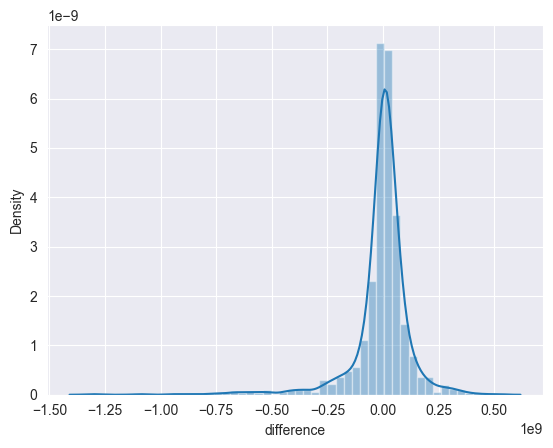

In [227]:
# Use best parameters
best_params = grid_search.best_params_ if search_for_best_hyperparameters else {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'max_iter': 100, 'warm_start': False}


mlp = MLPRegressor(**best_params)
mlp.fit(X_train, y_train)

# Evaluate the model
y_pred = mlp.predict(X_test)

print(f"Mean squared error of fine-tuned model: {mean_squared_error(y_test, y_pred)}")
print(f"Model Score of fine-tuend model: {mlp.score(X_test, y_test)}")
original_values = min_max_scaler.inverse_transform(y_pred.reshape(-1, 1))

# Create a dataframe with the predictions and the actual values
predictions_df = pd.DataFrame({
    'predicted_revenue': original_values.reshape(-1),
    'actual_revenue': min_max_scaler.inverse_transform(y_test.values.reshape(-1, 1)).reshape(-1)
})

predictions_df['difference'] = predictions_df['predicted_revenue'] - predictions_df['actual_revenue']

# Plot the difference
sns.distplot(predictions_df['difference'])

# Print the mean difference
print(f"Mean difference of fine-tuned model: {predictions_df['difference'].mean()}")

if save_models:
    with open('mlp_model_fine_tuned.pkl', 'wb') as f:
        pickle.dump(mlp, f)
        

K = 20 # To speed up the computation, we will use only a small amount of training examples in our background
background_data_summary = shap.sample(X_train, K)

explainer = shap.KernelExplainer(mlp.predict, background_data_summary)
shap_values = explainer.shap_values(X_test)

plt.savefig('models/shap/shap_mlp.png') if save_shape_plot else None
shap.summary_plot(shap_values, X_test)

In [228]:
# Have a look at the predictions
predictions_df.describe()

,predicted_revenue,actual_revenue,difference
count,1.092000e+03,1.092000e+03,1.092000e+03
mean,1.082574e+08,1.149582e+08,-6.700809e+06
std,1.347774e+08,1.971385e+08,1.381445e+08
min,-1.048771e+08,7.000000e+00,-1.307294e+09
25%,2.480987e+07,1.246333e+07,-2.478266e+07
50%,6.175133e+07,4.086450e+07,7.330276e+06
75%,1.375242e+08,1.291714e+08,4.364578e+07
max,1.069457e+09,1.921847e+09,5.163678e+08


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 100)               4600      
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_17 (Dense)            (None, 100)               10100     
                                                                 
 dropout_10 (Dropout)        (None, 100)               0         
                                                                 
 dense_18 (Dense)            (None, 100)               10100     
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


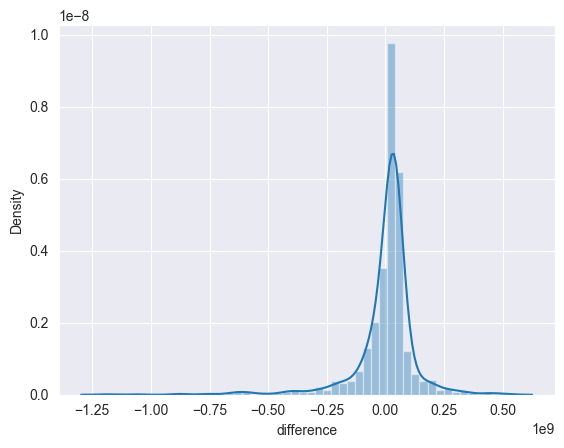

In [229]:
# Use Keras to create a neural network
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)

model = Sequential()
model.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mse'])

model.summary()

model.fit(X_train, y_train, epochs=100, batch_size=256, validation_split=0.2)

y_pred = model.predict(X_test)

print(f"Mean squared error of keras model: {mean_squared_error(y_test, y_pred)}")

# Evaluate the model
y_pred = model.predict(X_test)

print(f"Mean squared error of keras model: {mean_squared_error(y_test, y_pred)}")

original_values = min_max_scaler.inverse_transform(y_pred.reshape(-1, 1))

# Create a dataframe with the predictions and the actual values
predictions_df = pd.DataFrame({
    'predicted_revenue': original_values.reshape(-1),
    'actual_revenue': min_max_scaler.inverse_transform(y_test.values.reshape(-1, 1)).reshape(-1)
})

predictions_df['difference'] = predictions_df['predicted_revenue'] - predictions_df['actual_revenue']

# Plot the difference
sns.distplot(predictions_df['difference'])

print(f"Mean difference of keras model: {predictions_df['difference'].mean()}")

# Save model
if save_models:
    model.save('keras_model.h5')

# SHAP values
background_data_summary = shap.sample(X_train, K)
explainer = shap.KernelExplainer(model.predict, background_data_summary)
shap_values = explainer.shap_values(X_test)

plt.savefig('models/shap/shap_keras.png') if save_shape_plot else None
shap.summary_plot(shap_values, X_test)